# Yearly Maxima Return Level Estimation: Example 2 "Short"

This notebook provides a practical implementation using the `R` language of the guidelines for statistical analysis of yearly maxima edicted by the FOEN. We aim to estimate the return level function, and in particular the 10-year return level, of groundwater level that can be used as reference for civil engineering infrastructure design as well as groundwater protection measures. 

Example 2 "Short" is similar to Example 2 but analyses only the last five years of data to reproduce a situation where no long time series of measurements is available.

The analysis is performed thanks the the `R` language and requires mulitples `R` packages that need to be installed before starting the analysis. The latter can be done with commands such as `install.packages("lubridate")` exemplifying intallation of the lubridate package.

On the Renku platform, where the guildelines' notebooks are strored and shared, the project has been prepared with all packages installed for easiest reproduction.

In [1]:
# Load necessary libraries

# Library for easy date manipulation
library(lubridate) 

#Library for estimation of parametric models using l-moment matching
library(lmom)

#Library for estimation of parametric EVT models using maximum likelihood
library(evd)

# Library for automatic trend estimation
library(mgcv)

# Library for data manipulation
library(dplyr)

# Libraries for data plotting
library(ggplot2)
library(repr)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: nlme

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




With all necessary libraries now loaded, we import the data into the R environment. In our case, the data is stored as a `.csv` file with four columns and corresponding titles. Thanks to the `read.csv` function in `R`, we convert the csv into a data.frame object, the `R` representation of datasets, that has the following columns:
* Zeitstempel (date object): date (and time if available) of the measurement,
* Wert (numeric): measured groundwater level,
* Jahre (numeric): Year of the measurement used to compute yearly maxima,
* Zeitstempel_seit_ersten_wert (numeric): numerical time since the beginning of the measurements.

File format other than `.csv` are possible, but the `R` code must be adapted accordingly. Extensive documentation on data importation in `R` is widely available on the web.

In [2]:
# Read and import data from csv file
data <- read.csv("../data/data_groundwater_level_2.csv", header = TRUE, sep = ",")

# Converte date as string into date object
data$Zeitstempel <- ymd(data$Zeitstempel)

# Create column with year for block computation
data$Jahre <- (year(data$Zeitstempel))

#Create column with numerical time for trend estimation
data$Zeitstempel_seit_ersten_wert <- as.numeric(data$Zeitstempel) - as.numeric(data$Zeitstempel[1]) 

#Keep only the last five years
data <- data %>% filter(Zeitstempel > ymd("2018-12-31"))

# Display first 6 rows of the data 
head(data)

,Zeitstempel,Wert,Jahre,Zeitstempel_seit_ersten_wert
,<date>,<dbl>,<dbl>,<dbl>
1,2019-01-01,1700.30,2019,14974
2,2019-01-02,1700.30,2019,14975
3,2019-01-03,1700.33,2019,14976
4,2019-01-04,1700.35,2019,14977
5,2019-01-05,1700.30,2019,14978
6,2019-01-06,1700.29,2019,14979


Thanks to the created dataframe named `data`, we can now start the analysis. Before having a first look at the data, we compute the yearly maxima that we store into another dataframe.


In [3]:
#Compute dataframe of yearly maxima
data_yearly_maxima <- data %>%
                        group_by(Jahre) %>% # Groupe lines by year
                        summarize(Max = max(Wert, na.rm = TRUE),
                                  Date_maxima = Zeitstempel[which.max(Wert)]) # Compute yearly maxima and date of occurence

#Display first 6 rows of the dataframe
head(data_yearly_maxima) 

Jahre,Max,Date_maxima
<dbl>,<dbl>,<date>
2019,1701.36,2019-05-29
2020,1701.26,2020-08-31
2021,1701.76,2021-05-12
2022,1700.85,2022-05-21
2023,1701.34,2023-08-29


We now have all the relevant data to have a first look at the time series of measurement along with the corresponding yearly maxima.

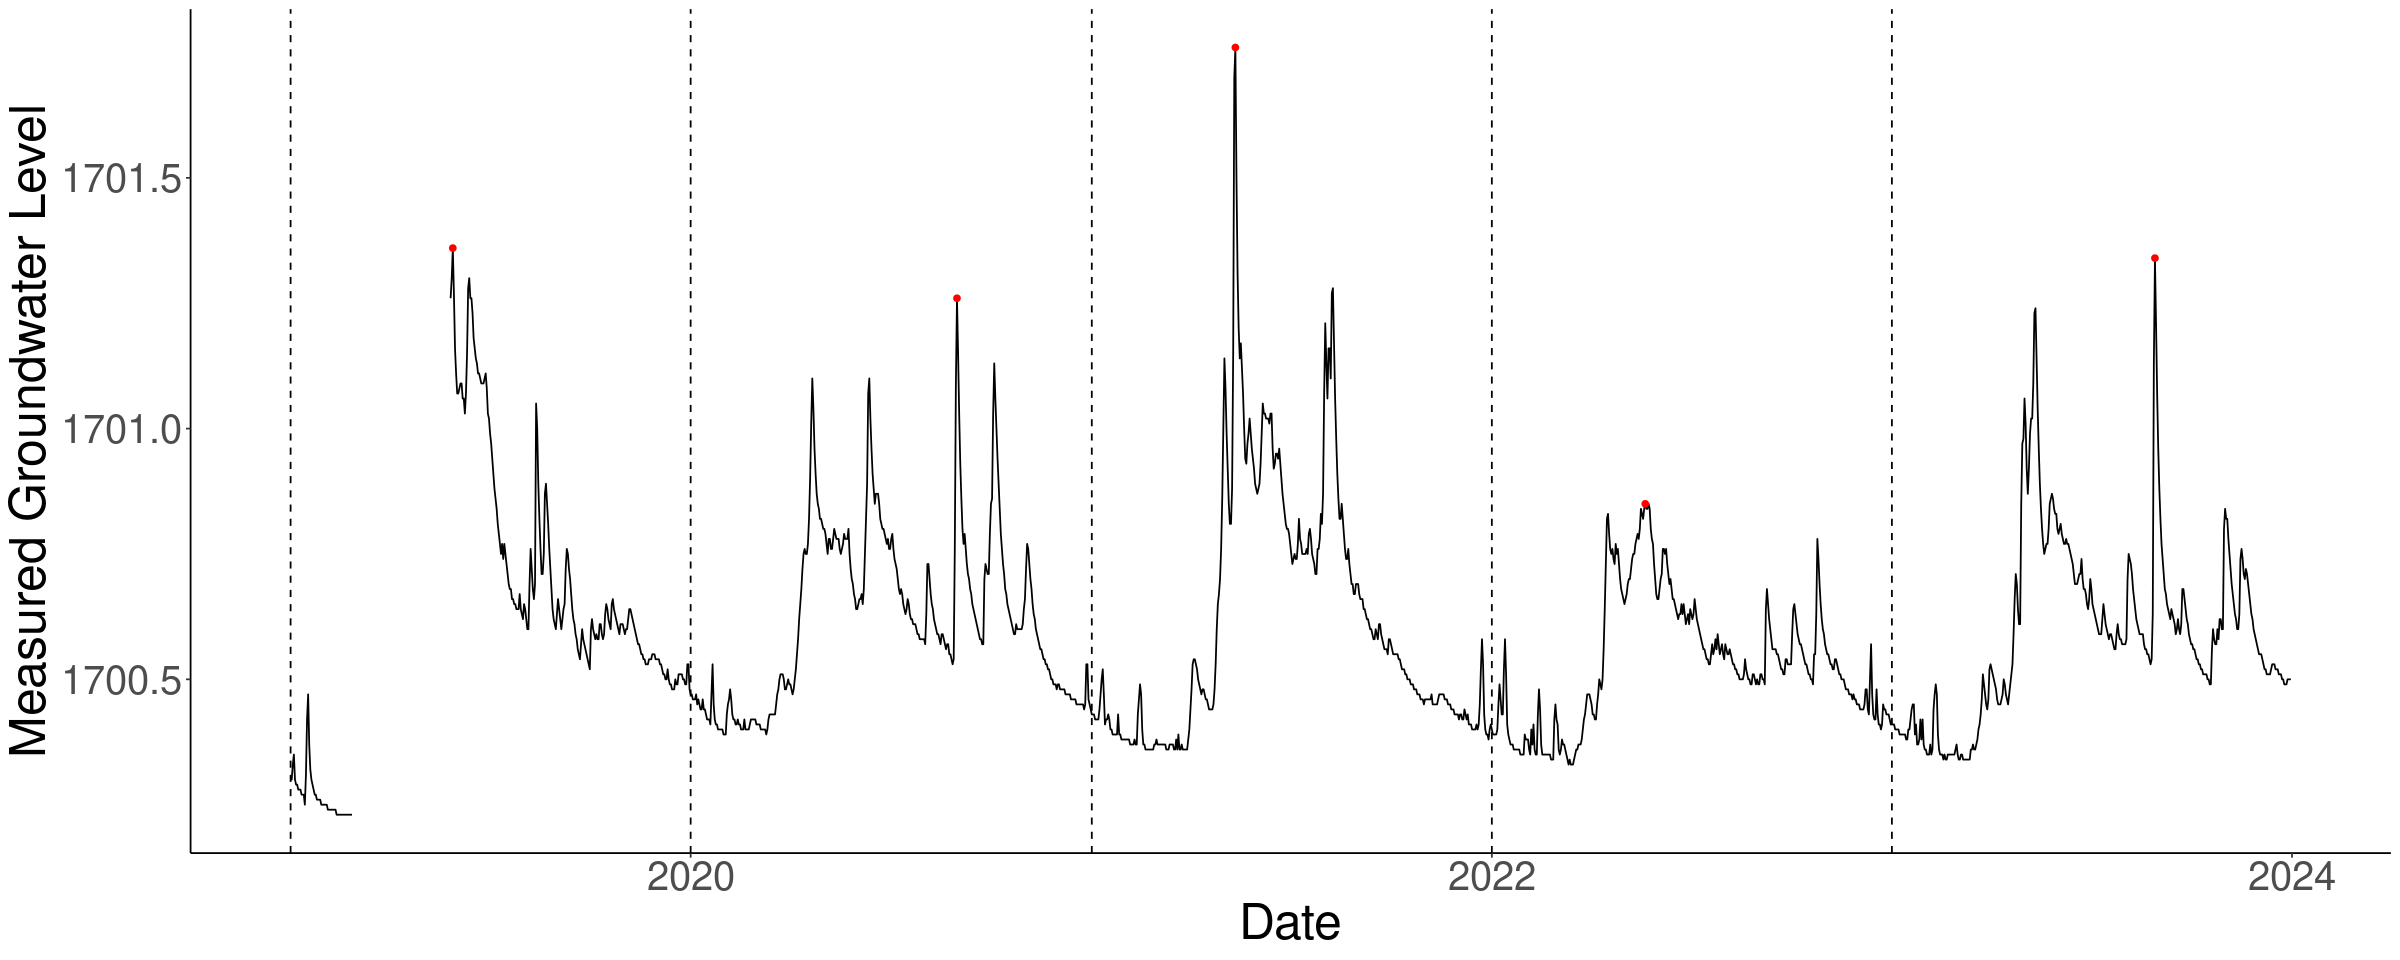

In [4]:
# Increase the plot size
options(repr.plot.width=20, repr.plot.height=8)

# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max), color = "red") + #add maxima as red points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))), linetype = "dashed") + #add vertical line for each year
    theme_classic() + #Change template
    theme(text = element_text(size = 30))+ #Increase test size
    xlab("Date") + # X axis name
    ylab("Measured Groundwater Level") #Y axis name

The above plots is extremely informative: we do not observe an obvious non-stationary trend in time. The distribution of the maxima can thus reasonably be assumed "identically distributed".
Also, even though there is missing data in 2019, it seems reasonable to assume that the yearly maxima has been observed. We thus keep the corresponding maxima for the analysis.
We will now check the second assumption, i.e., the independence of yearly maxima.

## Checking the independence of yearly maxima measurements

Independence of the yearly maxima will be checked thanks to an auto-correlation function: we compute the correlation between the maxima at year `y` and values at year `y + lag`. The empirical estimate of the function can be computed automatically using the function `acf`.

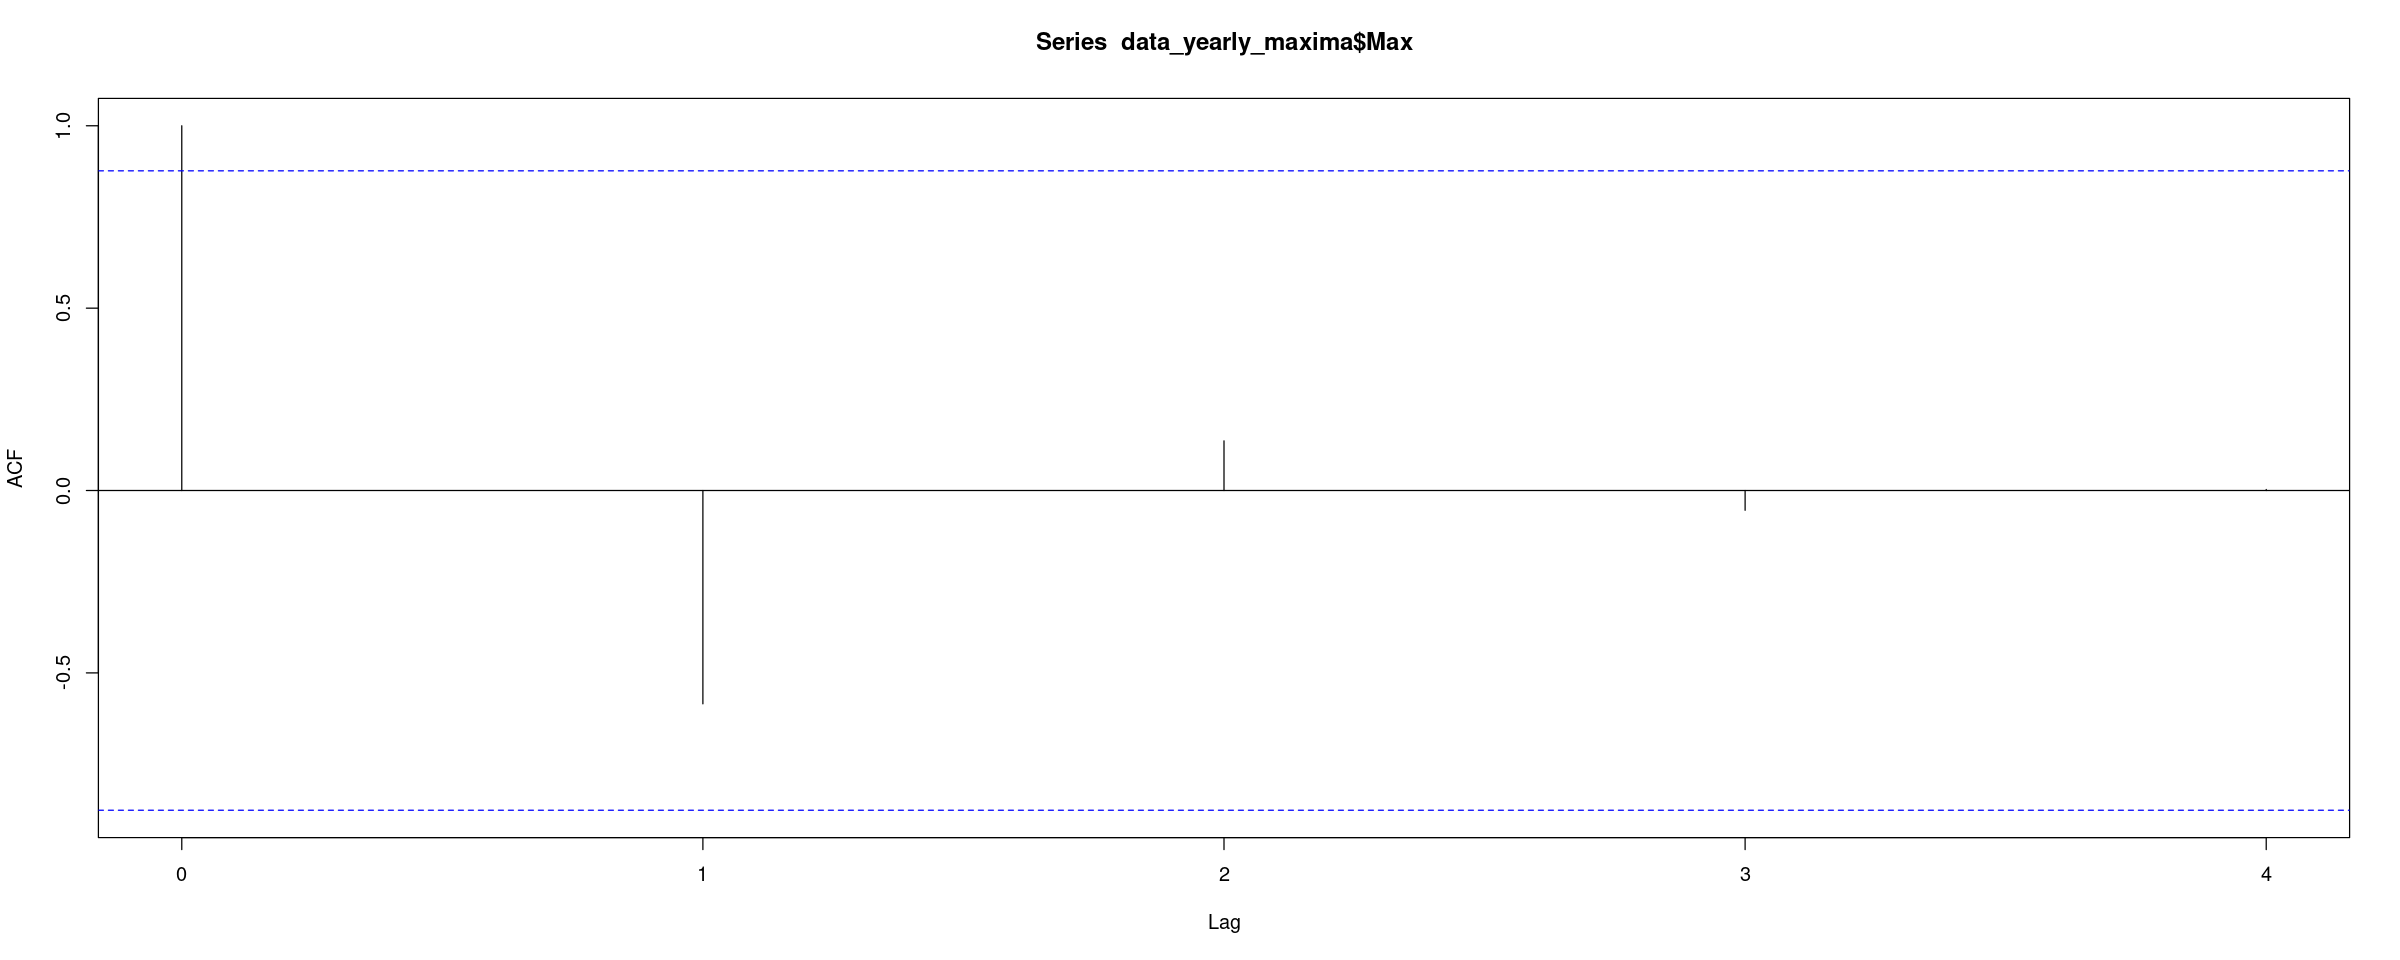

In [5]:
#Compute the auto-correlation between yearly maxima
acf(data_yearly_maxima$Max, lag = 4, na.action = na.pass)

The function's value at lag `0` is equal to `1` and corresponds to the perfect match between a maxima and itself. At lags `lag > 1`, the correlation remains below the dashed blue line, meaning that there is no evidence in favour of a correlation greater than `0`: the assumption of independence between measurements is reasonable and we can now move to the next step, i.e., model estimation and selection.

## Model estimation and selection

We estimate and select a parametric model for the block maxima observations. As we have less than `100` observations, we will prefer L-moment matching over maximum likelihood estimation as the former is known to provide more robust estimates for small sample sizes.

We consider three models:
* <ins> Generalized Extreme Value (GEV)</ins> : the model is theoretically motivated as it appears as the asymptotic distribution for the distribution of block maxima of increasing size. It is thus a natural candidate for observations representing the maxima over a block.
* <ins> Log-Pearson III</ins>: this model is extremely popular in hydrology. It is parametrized with the same number of parameters than the GEV, and is sometime found to be a better fit to the data. Its popularity makes it an important candidate.
* <ins> Weibull distribution</ins>: the Weibull model is a model of distribution admitting a lower bound. The Weibull family encompassed by GEV distributions is actually a reverse Weibull distribution, which is upper-bounded. However, it is also plausible that a lower bound may be more appropriate for the sample, particularly in the presence of a relatively small sample size. For this reason, fitting a Weibull distribution may yield better empirical results compared to the GEV.

We thus use the `R` package `lmom` to estimate the parameters the three candidate models.

In [6]:
#Comput l-moments of the observations
lmom <- samlmu(data_yearly_maxima$Max)

#Estimate GEV parameters
gev <- pelgev(lmom)

#Estimate log-Pearsonn III parameters
pIII <- pelpe3(lmom)

# Compute Weibull parameters
wei <- pelwei(lmom)

print("GEV Parameters:")
gev
print("Weibull Parameters:")
wei
print("Log-Pearson III:")
pIII

[1] "GEV Parameters:"


xi        alpha            k 
1701.2067580    0.3516169    0.3600781

[1] "Weibull Parameters:"


zeta        beta       delta 
1699.898700    1.545943    4.754443

[1] "Log-Pearson III:"


mu        sigma        gamma 
1701.3140000    0.3410067   -0.2556198

We now have parameter estimates for all the three candidate models. We will select the best fitting one by computing their respective negative-log likelihood and choosing the one with the lowest value.

In [7]:
print("Neg-log likelihood:")
(paste0("GEV: ",-sum(log(evd::dgev(data_yearly_maxima$Max, loc = gev[1], scale = gev[2], shape = -gev[3])))))
(paste0("Weibull: ",-sum(log(dweibull(data_yearly_maxima$Max - wei[1],scale = wei[2], shape = wei[3])))))
(paste0("Pearson3: ",-sum(log(dgamma(abs(data_yearly_maxima$Max - (pIII[1] - 2 *  pIII[2] /  pIII[3])), shape = 4/(pIII[3])^2, scale =  pIII[2] * abs(pIII[3]) / 2)))))

[1] "Neg-log likelihood:"


[1] "GEV: 0.986282931549921"

[1] "Weibull: 1.0054694405192"

[1] "Pearson3: 1.01211510275774"

We observe that the model with minimal negative log-likelihood is the GEV distribution corresponding to a reverse Weibull distribution. The latter yields parameters values that are more likely than both the Pearson III and the classical Weibull models.

We thus choose the GEV model to compute the return level function of the yearly maxima.

## Return level function estimation

The selected parametric model can be translated into a return level function, i.e., the expected groundwater level yearly maxima expected to be observed in average every return period (in years).

We also quantify the uncertainty associated to the estimated model in order to check if the selected model is consistent with the observed data. To do so, we will use a parametric boostrap method, i.e., a form a Monte Carlo sampling, that allows to quantify the uncertainty of the estimated return levels.

In [8]:
#Importa all necessary functions
source("utils.r")

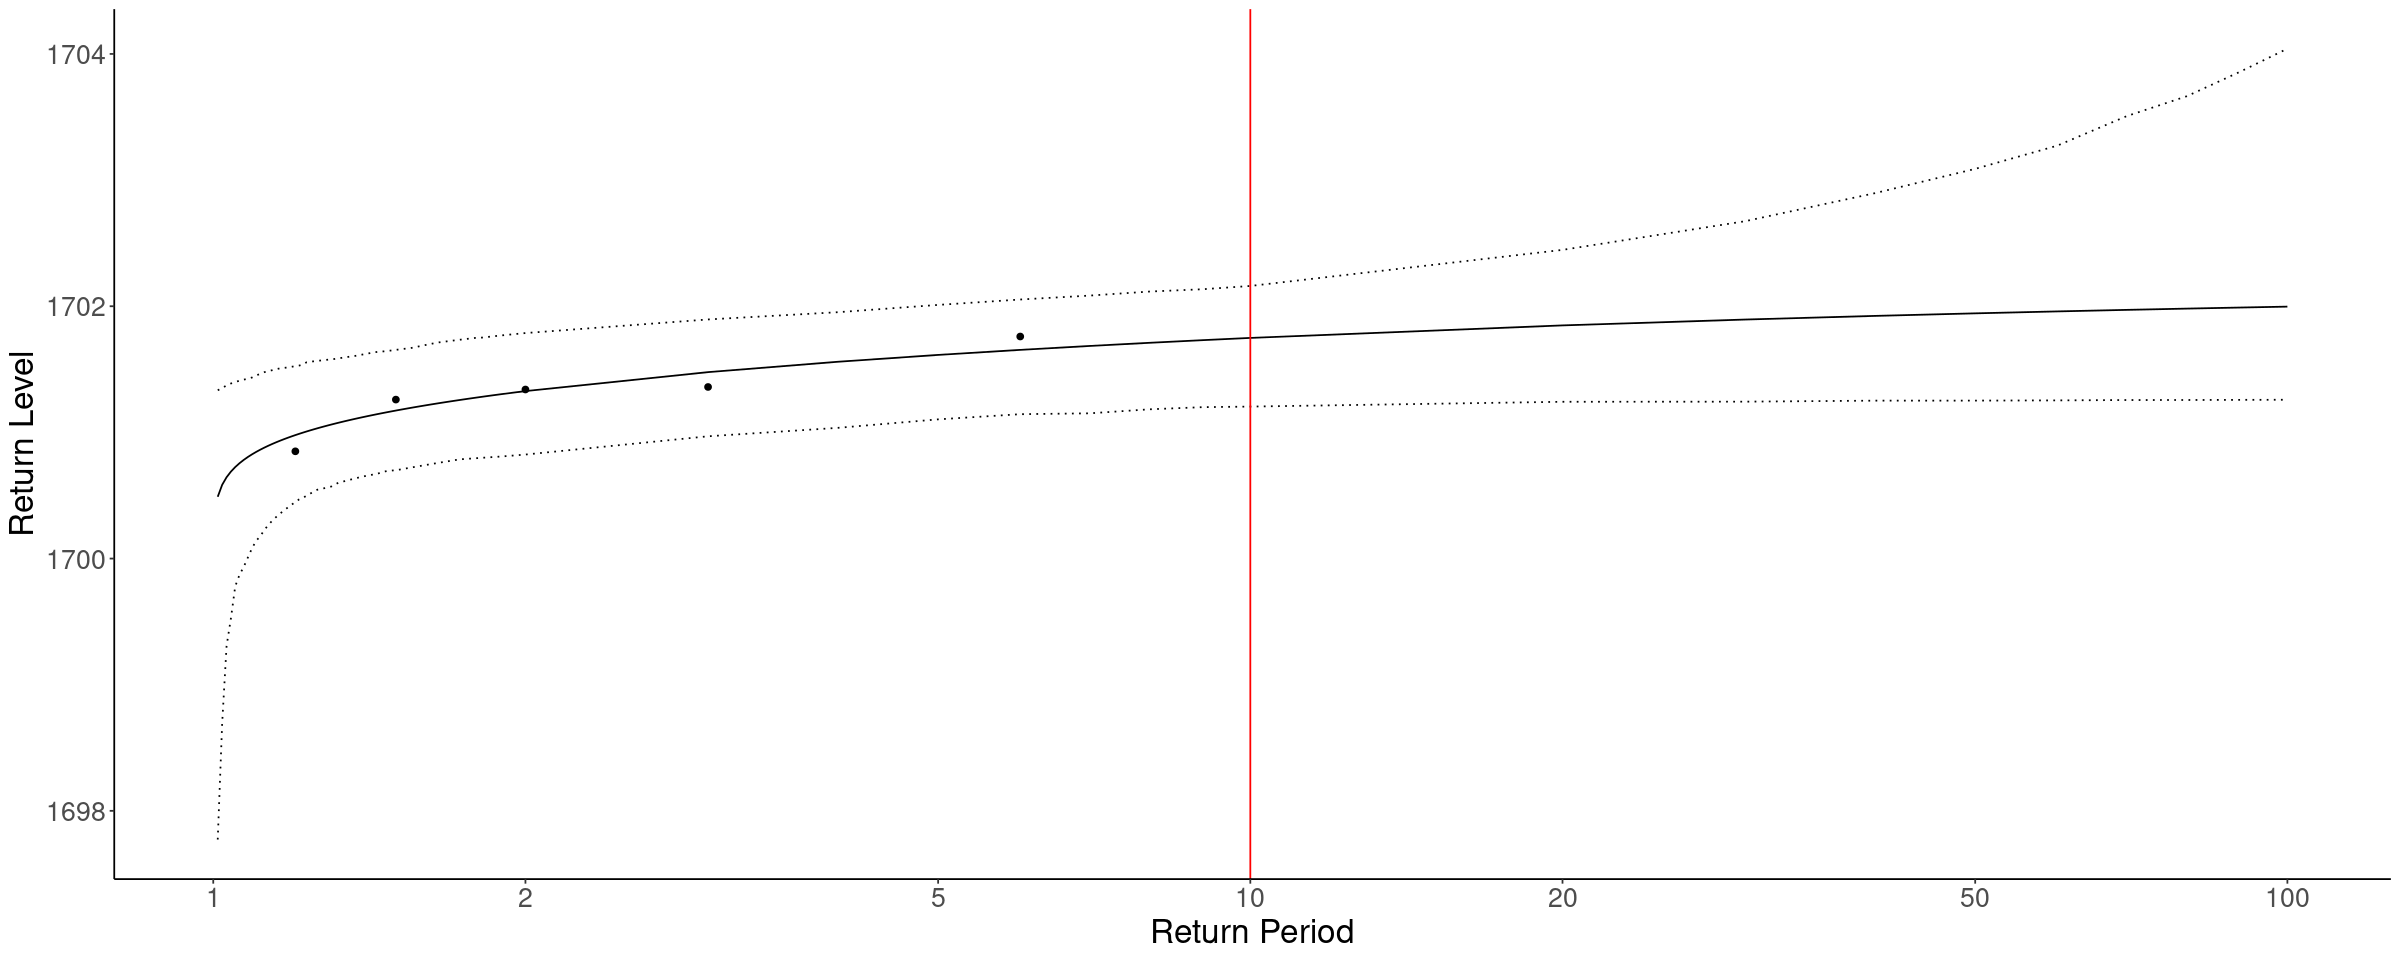

In [9]:
#Compute and plot the return level function and its associated uncertainty
display_return_level_function(data = data_yearly_maxima$Max,
                              parameters = gev)

We observe that all maxima lie inside the uncertainty bound, namely the 99% confidence interval represented by the dotted black lines: the estimated model is thus consistent with observations. The strenght of the parametric model described here is its capacity to extrapolate return level beyond the range of observed data. When using distributions covered by the GEV model such extrapolation is mathematically grounded in asymptotic theory.

We are now ready to compute the estimated return level for a given return period, in particular the 10 years return level that is particularly important for groundwater protection regulation.

*<ins>Note on uncertainty quantification</ins>*: the confidence interval is obtained thanks to a bootstrap procedure. By nature, such technique for uncertainty quantification is random so the CI values might differ slightly from one execution to the other. Either rounding values to a sufficiently rough approximate, or increasing the bootstrap sample size `m` (at the cost of an increased computing time), would limit such variability to a low enough level. Note also that this procedure might not be fully robust for the Weibull model because, for small sizes, generated samples might not be consistent with the existence of a lower bound yielding inconsistent empirical L-moments and need to be rejected.

In [10]:
# Compute the desires return level and its uncertainty
return_levels <- compute_return_levels(return_period = c(5,10,20,100), # Desired return periods
                                      parameters = gev, # Parameters estimated from the selected model
                                      n_obs = length(data_yearly_maxima$Jahre), #Number of observations use for the estimation
                                      m = 1000 # Number of bootstrap samples for uncertainty quantification
                                     )
return_levels

Return_period,Lower_99_CI_bound,Return_level,Upper_99_CI_bound
<dbl>,<dbl>,<dbl>,<dbl>
5,1701.105,1701.614,1702.003
10,1701.144,1701.749,1702.175
20,1701.245,1701.848,1702.458
100,1701.318,1701.997,1703.912


When comparing the 10 year return level obtained with the full time series (example_2) and only the last five years (example_2_short), we observe consistent and very close values, namely `1701.812 (1701.63;1702.01)` vs `1701.749 (1701.20;1702;14)`. Not surprisingly, the uncertainy is much larger when using only five years of data, with the confidence interval obtained with the full data set entirely included in the one obtained with only 5 years of data: this result illustrates the consistency of the guidelines presented here.